# implements the WR (Weather Regime) class

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import warnings

In [3]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
import os
import json
import numpy as np
import pandas as pd

In [5]:
import sys
sys.path.append('/Users/nicolasf/CODE/paleopy/')

In [6]:
from paleopy.core.proxy import proxy
from paleopy.core.composite import composite
from paleopy.plotting.scalar_plot import scalar_plot

In [7]:
proxies_num = pd.read_excel('./data/ProxiesLIANZSWP.xlsx', sheetname='numerical')

In [8]:
row = proxies_num.iloc[0,]

In [9]:
p = proxy(row.Site, row.Long, row.Lat, row.dataset, row.variable, 'DJF', value = row.Anom, \
          calc_anoms=True, detrend=True)

In [10]:
p.season

'DJF'

In [11]:
# extract the time-series
p.extract_ts()

print("{}{} --> {}{}: {} km".format(p.sitename, p.coords, p.variable, p.extracted_coords.tolist(), p.distance_point))

# calculates the season
p.calculate_season()

p.find_analogs()

Rarotonga(200.18000000000001, -21.23) --> sst[200.0, -22.0]: 87.56368858840081 km


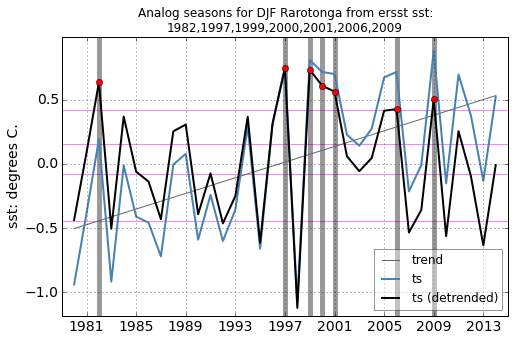

In [12]:
f = p.plot_season_ts()

In [13]:
%%writefile /Users/nicolasf/CODE/paleopy/paleopy/core/WR.py

import os
import sys
import numpy as np
import pandas as pd
import h5py
import json

from ..markov import *
from ..utils import seasons_params

class WR:

    """
    base class for weather regimes calculations and plots
    takes either a proxy or ensemble instance and either 'SW Pacific Regimes' or 'Kidson Types'
    """
    def __init__(self, obj, json_file='./jsons/WRs.json', classification='Kidson Types'):
        super(WR, self).__init__()
              
        # the parent can be either an instance of a `proxy` or `ensemble` class
        self.parent = obj
        
        self.json_file = json_file 
        self.classification = classification
        
        # get the season, and the analog years
        self.season = self.parent.season
        self.analog_years = self.parent.analog_years
        self.detrend = self.parent.detrend
        self.climatology = self.parent.climatology
        if self.parent.description == 'proxy': 
            self.sitename = self.parent.sitename
        
    def _get_WR_json(self): 
        with open(self.json_file, 'r') as f:
            dict_json = json.loads(f.read())
        return dict_json
            
    def _get_WR_ts(self): 
        if not(hasattr(self, 'dict_json')): 
            self.dict_json = self._get_WR_json()
        csv = self.dict_json[self.classification]['WR_TS']
        wr_ts = pd.read_csv(csv, parse_dates=True, index_col=0)
        return wr_ts
    
    def _get_WR_MC(self): 
        if not(hasattr(self, 'dict_json')): 
            self.dict_json = self._get_WR_json()
        f = h5py.File(self.dict_json[self.classification]['Markov Chains'], mode='r')
        MC_probs = f[self.season]['probs'].value
        MC_probs_classes = f[self.season]['probs'].attrs['classes']
        f.close()
        MC_probs_classes = MC_probs_classes.split(',')
        MC_probs = pd.DataFrame(MC_probs, index=MC_probs_classes)
        # reindex so that the index of the MC simulations follows the 
        # order of the types defined in the JSON file
        MC_probs = MC_probs.reindex(self.dict_json[self.classification]['types'])
        # The MC_probs contains the frequencies 
        # of each type in the 1000 simulations
        return MC_probs
        
    def _get_season_ts(self): 
        if not(hasattr(self,'wr_ts')): 
            wr_ts = self._get_WR_ts()
        ts = wr_ts.copy()
        ts.loc[:,'month'] = ts.index.month

        sparams = seasons_params.seasons_params()
        m = list(range(1,13)) + list(range(1,13))
        m = m[(sparams[self.season][1]-sparams[self.season][0]+12):(sparams[self.season][1]+12)]

        # selects the season
        ts_seas = ts[ts['month'].isin(m)]
        ts_seas = ts_seas.drop('month', axis=1)
        
        return ts_seas
    
    def _get_clim_probs(self): 
        if not(hasattr(self, 'ts_seas')): 
            ts_seas = self._get_season_ts()
        ts = ts_seas.ix[str(self.climatology[0]): str(self.climatology[1])].copy()
        types = self.dict_json[self.classification]['types']
        clim_probs = get_probs(ts['type'], types)
        # create a pandas.Series, index are the types
        clim_probs = pd.Series(clim_probs, index=types)
        return clim_probs
        
    def _get_compos_probs(self, analog_years): 
        """
        Arguments
        ---------
        
        analog_years : list
                       list of analog years
                       
        Return
        ------
        
        obs_probs : pandas.Series
                    observed probabilities
        """
        if not(hasattr(self, 'ts_seas')): 
            ts_seas = self._get_season_ts()
        ayears = list(map(str, analog_years))
        ts = ts_seas.copy()
        ts = pd.concat([ts.ix[l] for l in ayears])
        types = self.dict_json[self.classification]['types']
        obs_probs = get_probs(ts['type'], types)
        obs_probs = pd.Series(obs_probs, index=types)
        return obs_probs
    
    def probs_anomalies(self, kind='one', test=True): 
        """
        Arguments
        ---------
        
        kind : string
               if kind == 'one': 
                   either for a `proxy` or for all the years
                   in an `ensemble` as a whole
               if kind == 'many':
                   for each proxy record in an `ensemble` object
                       
        Return
        ------
        
        anoms_probs : pandas.Series
                      probabilities anomalies
        
        """
        
        # get the climatological probabilities, those are always the same
        clim_probs = self._get_clim_probs()
        
        if kind == 'one': 
            obs_probs = self._get_compos_probs(self.analog_years)
            anoms = obs_probs - clim_probs
            if self.parent.description == 'proxy': 
                self.df_anoms = pd.DataFrame(anoms, columns=[self.sitename])
                self.df_probs = pd.DataFrame(obs_probs, columns=[self.sitename])
            else: 
                self.df_anoms = pd.DataFrame(anoms, columns=['ensemble'])
                self.df_probs = pd.DataFrame(obs_probs, columns=['ensemble'])
            # if test, the percentiles values are added as columns to 
            # the df_probs pandas.DataFrame
            if test: 
                MC_probs = self._get_WR_MC()
                for tval in [0.1, 0.9, 0.05, 0.95, 0.01, 0.99]: 
                    c = str(int(tval * 100))
                    self.df_probs.loc[:,c] = MC_probs.T.quantile(tval)
                
        if kind == 'many':
            """
            we can only calculate `many` anomalies 
            if the object passed to the WR instance 
            is an `ensemble` object, raise an exception
            if that is not the case
            """
            if self.parent.description != 'ensemble':
                print("""
                ERROR! cannot calculate `many` anomalies with a proxy
                object: you need to pass an `ensemble` object to the 
                `WR` class
                """)
                raise Exception("KIND ERROR")
            else: 
                d_anoms = {}
                d_probs = {}
                d = self.parent.dict_proxies
                for k in d.keys():
                    obs_probs = self._get_compos_probs(analog_years = d[k]['analog_years'])
                    d_anoms[k] = obs_probs - clim_probs
                    d_probs[k] = obs_probs
                # df_probs contains the ANOMALIES in frequencies (probabilities)
                # for the composite years for each proxy in the ensemble
                # index = types
                # columns = proxies 
                self.df_anoms = pd.DataFrame(d_anoms)
                # df_probs contains the OBSERVED frequencies (probabilities)
                # for the composite years for each proxy in the ensemble
                # index = types
                # columns = proxies
                self.df_probs = pd.DataFrame(d_probs)
            # if test, we add another DataFrame to the object, containing the
            # percentile values coming from the MC simulation
            if test: 
                MC_probs = self._get_WR_MC()
                df_probs_MC = pd.DataFrame()
                for tval in [0.1, 0.9, 0.05, 0.95, 0.01, 0.99]: 
                    c = str(int(tval * 100))
                    df_probs_MC.loc[:,c] = MC_probs.T.quantile(tval)
                self.df_probs_MC = df_probs_MC

Overwriting /Users/nicolasf/CODE/paleopy/paleopy/core/WR.py


In [14]:
from paleopy.core.WR import WR

### try with a proxy object

In [15]:
w = WR(p, classification='SW Pacific Regimes')

In [16]:
obs_probs = w._get_compos_probs(w.analog_years)

In [17]:
w.probs_anomalies()

In [18]:
w.df_probs

,Rarotonga,10,90,5,95,1,99
SW1,0.166403,0.186091,0.226634,0.179576,0.232346,0.171953,0.240352
SW2,0.120444,0.105464,0.136072,0.101242,0.140256,0.093993,0.151326
SW3,0.109350,0.143294,0.181123,0.138326,0.186473,0.129920,0.197554
SW4,0.218700,0.137142,0.170424,0.131830,0.176538,0.123416,0.185716
SW5,0.120444,0.110050,0.139091,0.106209,0.144058,0.099347,0.153244
SW6,0.264659,0.210164,0.255636,0.203668,0.262151,0.191819,0.275888


In [19]:
# f, ax = plt.subplots(figsize=(10,10))
# # ax.plot(w.MC_probs.T.quantile(0.05))
# # ax.plot(w.MC_probs.T.quantile(0.95))
# ax.fill_between(range(12), w.MC_probs.T.quantile(0.1), w.MC_probs.T.quantile(0.9), color='0.1', alpha=0.9)
# ax.fill_between(range(12), w.MC_probs.T.quantile(0.05), w.MC_probs.T.quantile(0.95), color='0.6', alpha=0.6)
# ax.fill_between(range(12), w.MC_probs.T.quantile(0.01), w.MC_probs.T.quantile(0.99), color='0.2', alpha=0.4)

# ax.plot(obs_probs, color='r')
# ax.plot(clim_probs, color='b')


# ax.set_xlim(-0.5, 11.5)
# ax.set_xticks(range(12))
# ax.set_xticklabels(w.dict_json[w.classification]['types']); 

### try with passing an `ensemble` object 

In [20]:
jsons = './jsons/proxies/'

In [21]:
from paleopy.core.ensemble import ensemble

In [22]:
ens = ensemble(jsons, season='DJF')

In [23]:
# w = WR(ens, classification='SW Pacific Regimes')
w = WR(ens, classification='Kidson Types')

In [24]:
w.parent.description

'ensemble'

In [25]:
w.climatology

[1981, 2010]

In [26]:
w.probs_anomalies()

In [27]:
w.probs_anomalies(kind='many')

In [92]:
%%writefile /Users/nicolasf/CODE/paleopy/paleopy/utils/make_sig.py
def make_sig(df_probs, df_probs_MC, sig=90, array=True): 
    sigdf = []
    for icol in range(df_probs.shape[1]):
        col = df_probs.iloc[:,icol]
        sigdf.append((col < df_probs_MC.loc[:,str((100 - sig))]) | (col > df_probs_MC.loc[:,str(sig)]))
    sigdf = pd.concat(sigdf, axis=1)
    sigdf.columns = df_probs.columns
    if array: 
        sigdf = sigdf.T
        sigarray = sigdf.values[::-1,:]
        return sigarray
    else: 
        return sigdf

Writing /Users/nicolasf/CODE/paleopy/paleopy/utils/make_sig.py


In [93]:
%%writefile /Users/nicolasf/CODE/paleopy/paleopy/plotting/heatmap.py
def heatmap(df_anoms, df_probs, df_probs_MC): 
    sig90 = make_sig(df_probs, df_probs_MC, sig=90)
    sig95 = make_sig(df_probs, df_probs_MC, sig=95)
    sig99 = make_sig(df_probs, df_probs_MC, sig=99)
    
    df_anoms = df_anoms * 100
    df_anoms = df_anoms.T
    anoms = df_anoms.values[::-1,:]
    
    vmax = np.ceil(np.abs([anoms.min(),anoms.max()]).max())
    vmin = -1 * vmax

    width, height = plt.figaspect(anoms)
    fig, ax = plt.subplots(figsize=(10, 10))

    #fig = plt.figure(figsize=(12,10))
    #ax = fig.add_subplot(gs[2::,2::])

    X = np.arange(df_anoms.shape[1])
    Y = np.arange(0.5, df_anoms.shape[0] + 0.5)
    # im = ax.pcolormesh(X, Y, anoms,vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r) 
    im = ax.pcolormesh(anoms,vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r) 

    for i in range(anoms.shape[0]):
        for j in range(anoms.shape[1]): # maybe not hard code that 
            if sig95[i,j]:
                ax.plot(j+0.50,i+0.50, "s",  color='k', markersize=11, markerfacecolor='None')
            if sig99[i,j]:
                ax.plot(j+0.50,i+0.50, "+",  color='k', markersize=11, markerfacecolor='None')

    ax.set_yticks(np.arange(0.5, anoms.shape[0] + 0.5))
    ax.set_yticklabels(df_anoms.index[::-1])

    ax.set_xticks(np.arange(0.5, anoms.shape[1] + 0.5))
    ax.set_xticklabels(df_anoms.columns)


    cb = plt.colorbar(im, ticks=np.linspace(vmin, vmax, 11), boundaries=np.linspace(vmin, vmax, 11), drawedges=True)

    return fig

Writing /Users/nicolasf/CODE/paleopy/paleopy/plotting/heatmap.py
